# Preliminary modelling 
The following notebook first prepares the available data in order to conduct the preliminary modelling.

## Preparation

In [1]:
# Clear namespace
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

Import libraries

In [2]:
# Data manipulation
import numpy as np
import pandas as pd

# Ploting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Scientific computing
import scipy as sp

# Machine Learning
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# Safe models
import pickle

C:\Local\Software\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Local\Software\Anaconda\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Functions
(necessary for the following calculations)

In [3]:
#--------  table
# A function that is similar to the R table function
# Input: 
#      x (x values)
# Returns: 
#      table (table)

def table(x):
    table = pd.DataFrame(x.value_counts(dropna=True))
    return table

#--------  Scatter Plot
# A function that visualizes the data
# Input: 
#      x (variable on the x-axis)
#      y (variable on the y_axis)
#      df (panda data frame)
#      group (grouping variable, i.e., variable to plot)
#      col (vector of colors)
#      alpha (alpha value for colors)
#      size (size of the dots)
#      title (title of the plot)
#      marker (shape of the marker, default to 'o')
#      add_line (add a line plot)
#      linewidth (thinkness of the added line)
#      figsize (size of the figure)

def scatter_plot(x, y, df, group, col, alpha, size, title, marker='o', add_line=False, linewidth=1, figsize=(15, 10)):
    
    # Define plot
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()

    # Extract unique categories
    cat = df[group].unique()

    # Loop trough categories
    for i in range(0, len(cat)) :
            ax.scatter(df[x][df[group] == cat[i]].values,
                       df[y][df[group] == cat[i]].values,
                       c=col[i], alpha=alpha, s=size,
                       label=cat[i], edgecolors='none',
                       marker=marker)
    # Add line plot
    if add_line:
            for i in range(0, len(cat)) :
                ax.plot(df[x][df[group] == cat[i]].values,
                           df[y][df[group] == cat[i]].values,
                           c=col[i], alpha=alpha, linewidth=linewidth)

    # Add legend, grid etc.
    ax.legend(loc=0, scatterpoints = 1) # Legend with just one dot
    ax.set_xlabel(x); ax.set_ylabel(y)
    ax.set_title(title)
    plt.grid()
    
#--------  random_classifier
# A function that builds a random classifier
# Input: 
#      df_y    (Panda df of the y variable)
# Returns: 
#      pred    (Random zero one class with the same proportion)

def random_classifier(df_y):
    # Transform y to panda dataframe
    prop = df_y["y"].value_counts() / df_y.shape[0]

    pred = np.random.binomial(1, prop[0], df_y.shape[0])

    return pred


#--------  cartesian
# A function that creates the cartesian product/combination
# Input: 
#      x1    (numpy vector 1)
#      x2    (numpy vector 2)
# Returns: 
#      cartesian combination
def cartesian(x1, x2):
    return np.transpose([np.tile(x1, len(x2)), np.repeat(x2, len(x1))])

#--------  cartesian
# A function that creates "risk cells" out of the longitude/latitude combination. That means in 
# seperates a x, y plane into n cells.
# Input: 
#      longitude
#      latitude
#      n_cells
# Returns: 
#      risk cells
def create_risk_cells(longitude, latitude, n_cells):
    n = int(np.sqrt(n_cells))
    x1 = np.zeros(n)
    x2 = np.zeros(n)

    min_long = min(longitude)
    min_lat = min(latitude)
    step_long = (max(longitude) - min(longitude)) / n
    step_lang = (max(latitude) - min(latitude)) / n
    
    for i in range(0, n):
        x1[i] = min_long + (step_long * i)
        x2[i] = min_lat + (step_lang * i) 
        
    return pd.DataFrame(cartesian(x1, x2))


## 1: Importing Data

Importing the three datasets for the following modelling.

In [4]:
# load business data
df_business = pd.read_csv('data/Business_Licenses.csv')

C:\Local\Software\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (9,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# load crime data
df_crimes = pd.read_csv('data/Crimes_-_2001_to_present.csv')

In [6]:
# load food inspection data
df_inspection = pd.read_csv('inspection_merged_climate.csv')

In [68]:
# Load sanitation data
df_sanitation = pd.read_csv('data/311_Service_Requests_-_Sanitation_Code_Complaints.csv')

## 2: Data Cleaning

Business data

In [7]:
# Transform column headers to lower case
df_business.columns = map(str.lower, df_business.columns)

# Replace whitespace in headers
df_business.columns = [x.strip().replace(' ', '_') for x in df_business.columns]

# Format to datetime string
df_business['license_term_start_date'] =  pd.to_datetime(df_business['license_term_start_date'], format='%m/%d/%Y')
df_business['license_term_expiration_date'] =  pd.to_datetime(df_business['license_term_expiration_date'], format='%m/%d/%Y')
df_business['license_approved_for_issuance'] =  pd.to_datetime(df_business['license_approved_for_issuance'], format='%m/%d/%Y')
df_business['date_issued'] =  pd.to_datetime(df_business['date_issued'], format='%m/%d/%Y')
df_business['application_created_date'] =  pd.to_datetime(df_business['application_created_date'], format='%m/%d/%Y')

# Filter
#df_business = df_business[~((df_business['application_type'] == 'C_CAPA') | (df_business['application_type'] == 'C_SBA'))]

# Exclude NA's
#df_business = df_business[~pd.isnull(df_business['license_term_start_date'])]
#df_business = df_business[~pd.isnull(df_business['license_term_expiration_date'])]


Crime data

In [8]:
# Transform column headers to lower case
df_crimes.columns = map(str.lower, df_crimes.columns)

# Replace whitespace in headers
df_crimes.columns = [x.strip().replace(' ', '_') for x in df_crimes.columns]

# Select only 2015 data
df_crimes_2015 = df_crimes[df_crimes['year'] == 2015]
df_crimes_2015.head()

# Exclude NA's
df_crimes_2015 = df_crimes_2015[~pd.isnull(df_crimes_2015['latitude'])]


Inspection data

In [9]:
# Transform column headers to lower case
df_inspection.columns = map(str.lower, df_inspection.columns)

# Replace whitespace in headers
df_inspection.columns = [x.strip().replace(' ', '_') for x in df_inspection.columns]

# Replace question mark (?) with whitespace in headers
df_inspection.columns = [x.strip().replace('?', ' ') for x in df_inspection.columns]

# Replace colon (:) with whitespace in headers
df_inspection.columns = [x.strip().replace(':', '') for x in df_inspection.columns]

# Replace double unserscore (__) with underscore (_) in headers
df_inspection.columns = [x.strip().replace('__', '_') for x in df_inspection.columns]

# Drop id row 
df_inspection = df_inspection.drop('unnamed_0', axis=1)

# Renaming
df_inspection = df_inspection.rename(columns={'license_#':'license_id'})

In [10]:
# Count missings in licence_id
print df_inspection['license_id'].isnull().value_counts()

False    118166
True         13
Name: license_id, dtype: int64


Sanitation data

In [82]:
# Transform column headers to lower case
df_sanitation.columns = map(str.lower, df_sanitation.columns)

# Replace whitespace in headers
df_sanitation.columns = [x.strip().replace(' ', '_') for x in df_sanitation.columns]

In [83]:
# Remove missings
df_inspection = df_inspection.loc[~df_inspection['license_id'].isnull(), :]
df_sanitation = df_sanitation.loc[~df_sanitation['longitude'].isnull(), :]

# Format lycence id to int
df_inspection['license_id'] = df_inspection['license_id'].astype(int)
df_inspection['zip'] = df_inspection['zip'].fillna(0.0).astype(int)


In [12]:
# select only relevant columns from businesses
df_business_merge = df_business[['license_id', 'address', 'city', 'ward', 'police_district', 'license_description', 'application_created_date', 'conditional_approval', 'license_status']]

In [13]:
# Left join
df_merge = pd.merge(df_inspection, df_business_merge, how='left', left_on='license_id', right_on='license_id', left_index=False, right_index=False)

Add crime data

In [14]:
x_train = create_risk_cells(df_crimes_2015.longitude, df_crimes_2015.latitude, 100*100)
y_train = pd.Series(range(0, x_train.shape[0], 1))


In [15]:
knn = KNN(n_neighbors=1)
fit_knn = knn.fit(x_train.values, y_train.values)

x_test = df_crimes_2015[["longitude", "latitude"]].values
df_crimes_2015['cluster'] = pd.DataFrame(fit_knn.predict(x_test)).values


Add sanitation data

In [91]:
df_sanitation.loc[:, 'cluster'] = pd.DataFrame(fit_knn.predict(df_sanitation[["longitude", "latitude"]].values)).values

In [103]:
df_crimes_2015.category = df_crimes_2015.primary_type
df_crimes_2015.loc[~df_crimes_2015.primary_type.isin(['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'OTHER OFFENSE', 'ASSAULT', 'DECEPTIVE PRACTICE', 'BURGLARY', 'MOTOR VEHICLE THEFT']), 'category'] = "OTHER OFFENSE"
df_theft = df_crimes_2015.loc[df_crimes_2015.primary_type == 'THEFT', :]
df_burglary = df_crimes_2015.loc[df_crimes_2015.primary_type == 'BURGLARY', :]
df_other_crime = df_crimes_2015.loc[~df_crimes_2015.primary_type.isin(['THEFT', 'BURGLARY']), :]


In [104]:
# Create Heatmap
crime_map = df_theft.groupby('cluster').size()
df_theft = pd.DataFrame({'cluster_name': pd.Series(crime_map.index), 'crime_count_theft': pd.Series(crime_map.values)})

# Create Heatmap
crime_map = df_burglary.groupby('cluster').size()
df_burglary = pd.DataFrame({'cluster_name': pd.Series(crime_map.index), 'crime_count_burglary': pd.Series(crime_map.values)})

# Create Heatmap
crime_map = df_other_crime.groupby('cluster').size()
df_other_crime = pd.DataFrame({'cluster_name': pd.Series(crime_map.index), 'crime_count_other_crime': pd.Series(crime_map.values)})

# Sanitation data
sanitation_map = df_sanitation.groupby('cluster').size()
df_sanitation_map = pd.DataFrame({'cluster_name': pd.Series(sanitation_map.index), 'sanitation_violation_count': pd.Series(sanitation_map.values)})


In [105]:
# Merge all together
df_merge = df_merge.loc[~df_merge.longitude.isnull(), :]
x_test = df_merge[["longitude", "latitude"]].values
df_merge['cluster'] = pd.DataFrame(fit_knn.predict(x_test)).values

# Left join
df_merge_crime = pd.merge(df_merge, df_theft, how='left', left_on='cluster', right_on='cluster_name', left_index=False, right_index=False)
df_merge_crime = pd.merge(df_merge_crime, df_burglary, how='left', left_on='cluster', right_on='cluster_name', left_index=False, right_index=False)
df_merge_crime = pd.merge(df_merge_crime, df_other_crime, how='left', left_on='cluster', right_on='cluster_name', left_index=False, right_index=False)
df_merge_crime = pd.merge(df_merge_crime, df_sanitation_map, how='left', left_on='cluster', right_on='cluster_name', left_index=False, right_index=False)


In [19]:
# Calculate cluster proportion of previous failures
#fail_sum = df_merge_crime[['y_fail', 'cluster']].groupby(['cluster']).sum()
#fail_count = df_merge_crime[['y_fail', 'cluster']].groupby(['cluster']).count()
#df_cluster = pd.DataFrame({'cluster_name': pd.Series(fail_sum.y_fail.index), 'failed_inspections': pd.Series(fail_sum.y_fail.values), 'sum_inspections': pd.Series(fail_count.y_fail.values)})
#df_cluster['proportion_prev_failed'] = df_cluster.failed_inspections / df_cluster.sum_inspections


In [20]:
# Merge all together
#df_merge_crime = pd.merge(df_merge_crime, df_cluster[['cluster_name', 'proportion_prev_failed']], how='left', left_on='cluster', right_on='cluster_name', left_index=False, right_index=False)

Further cleanup

In [106]:
# Replace inspection values where the n of occurances is smaller than 30
inspection_type_table = df_merge_crime['inspection_type'].value_counts()
list_smaller_30 = inspection_type_table[inspection_type_table < 30].index.values
index_smaller_30 = df_merge_crime['inspection_type'].isin(list_smaller_30)
df_merge_crime.loc[index_smaller_30, 'inspection_type'] = "Other"


In [107]:
# Set missings to zero
df_merge_crime.loc[df_merge_crime.days_since_last_inspection.isnull(), 'days_since_last_inspection'] = 0

# Remove missings
df_merge_crime = df_merge_crime.loc[~df_merge_crime.tmax_5.isnull(), :]

In [147]:
# Extract x and y
y = df_merge_crime[['y']]
x = df_merge_crime.drop(['y', 'y_description', 'license_id'], axis=1)

In [148]:
# Handle inspection date
x.loc[:, 'inspection_date_string'] = pd.to_datetime(x['inspection_date_string'])
x.loc[:, 'inspection_weekday'] = x['inspection_date_string'].dt.weekday_name
x.loc[:, 'inspection_week'] = x['inspection_date_string'].dt.week

In [149]:
x.loc[:, 'inspection_weekday'] = x['inspection_date_string'].dt.weekday_name

In [150]:
x = x.drop(['inspection_dt', 'zip', 'child', 'inspection_type', 'address', 'city', 'license_description',
           'application_created_date', 'y_fail', 'cluster_name_x', 'cluster_name_y', 'latitude', 'longitude'], axis=1)

# Recode 'pass with condition' to pass
y = y.astype(int)
y[y > 1] = 1 

In [151]:
# Handle missings
x.loc[:, x.dtypes == "int32"] = x.loc[:, x.dtypes == "int32"].fillna(0)
x.loc[:, x.dtypes == "float64"] = x.loc[:, x.dtypes == "float64"].fillna(0.0)
x.loc[:, x.dtypes == "int64"] = x.loc[:, x.dtypes == "int64"].fillna(0)
x.loc[:, x.dtypes == "object"] = x.loc[:, x.dtypes == "object"].fillna('Missing')
x.loc[:, x.dtypes == "datetime64[ns]"] = x.loc[:, x.dtypes == "datetime64[ns]"].fillna('Missing')

In [152]:
# Get dummy variables
x = pd.get_dummies(x)

In [161]:
# Take last 60 days
x_60_day = x.loc[x.inspection_date_string >= '2016.09.01', :]
y_60_day = y.loc[x.inspection_date_string >= '2016.09.01', :]

In [154]:
# Take last 60 days
x_other = x.loc[x.inspection_date_string < '2016.09.01', :]
y_other = y.loc[x.inspection_date_string < '2016.09.01', :]

In [181]:
# Create testing and training set (70% Train, 30% Test)
np.random.seed(123) # Set random seed
x_train, x_test, y_train, y_test = train_test_split(x_other, y_other, test_size=0.3)

x_train = x_train.drop(['inspection_date_string'], axis=1)
x_test = x_test.drop(['inspection_date_string'], axis=1)
x_60_day = x_60_day.drop(['inspection_date_string'], axis=1)

## Baseline model

For the baseline model there are two natural choice. The first is to assume that every restaurant is potentially going to fail. So every class is set to zero. The second model is to randomly classify the restaurants according to the proportion.  

In [163]:
#--------  zero_class
# A function that builds a random classifier
# Input: 
#      df_y    (Panda df of the y variable)
# Returns: 
#      pred    (Random zero one class with the same proportion)

def zero_class(df_y):
    pred = np.repeat(0, df_y.shape[0])

    return pred

In [164]:
y_test_pred = zero_class(y_test)
model_accuracy = np.mean(y_test_pred == y_test.y)

print "Zero model accuracy", round(model_accuracy * 100, 2), "%\n"
print "Confusion matrix (zero model):"
pd.crosstab(y_test.y, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Zero model accuracy 22.26 %

Confusion matrix (zero model):


Predicted,0,All
True,,
0,7635,7635
1,26657,26657
All,34292,34292


The zero model has an accuracy of 22.28%. This is to be assumed as the target variable is unbalanced.

In [165]:
np.random.seed(123) # Set random seed
y_test_pred = random_classifier(y_test)
model_accuracy = np.mean(y_test_pred == y_test.y)

print "Random model accuracy", round(model_accuracy * 100, 2), "%\n"
print "Confusion matrix (random model):"
pd.crosstab(y_test.y, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Random model accuracy 34.26 %

Confusion matrix (random model):


Predicted,0,1,All
True,,,
0,5921,1714,7635
1,20829,5828,26657
All,26750,7542,34292


The random model has an accuracy of around 34% which is better than the zero class model, i.e., the model that assumes that every restaurant is going to fail. The 34% serve as the baseline accuracy rate that has to be beaten. 

## Random forest

In [182]:
# Random forest model
np.random.seed(123) # Set random seed
rf_model = RandomForestClassifier(n_estimators=100, oob_score=True, class_weight="balanced").fit(x_train, y_train.y)

In [183]:
y_test_pred = rf_model.predict(x_test)
model_accuracy = np.mean(y_test_pred == y_test.y)

print "Random forest accuracy", round(model_accuracy * 100, 2), "%\n"
print "Confusion matrix (random forest model):"
pd.crosstab(y_test.y, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Random forest accuracy 82.95 %

Confusion matrix (random forest model):


Predicted,0,1,All
True,,,
0,3759,3876,7635
1,1970,24687,26657
All,5729,28563,34292


As can be seen, the random forest performs much better than the baseline model. 

## Decision Tree

In [184]:
# Decision Tree
np.random.seed(123) # Set random seed
tree_fit = DecisionTree(max_depth=100, class_weight="balanced").fit(x_train, y_train)

In [185]:
y_test_pred = tree_fit.predict(x_test)
model_accuracy = np.mean(y_test_pred == y_test.y)

print "Single tree accuracy", round(model_accuracy * 100, 2), "%\n"
print "Confusion matrix (Tree):"
pd.crosstab(y_test.y, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Single tree accuracy 79.67 %

Confusion matrix (Tree):


Predicted,0,1,All
True,,,
0,4049,3586,7635
1,3384,23273,26657
All,7433,26859,34292


## ADA Boost

In [186]:
# ADA Boost
np.random.seed(123) # Set random seed
ada_fit = AdaBoostClassifier().fit(x_train, y_train.y)

In [187]:
y_test_pred = ada_fit.predict(x_test)
model_accuracy = np.mean(y_test_pred == y_test.y)

print "ADA boost accuracy", round(model_accuracy * 100, 2), "%\n"
print "Confusion matrix (ADA boost):"
pd.crosstab(y_test.y, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)

ADA boost accuracy 81.07 %

Confusion matrix (ADA boost):


Predicted,0,1,All
True,,,
0,3537,4098,7635
1,2393,24264,26657
All,5930,28362,34292


## LDA

In [188]:
# LDA
lda_fit = LDA().fit(x_train, y_train.y)

In [189]:
y_test_pred = lda_fit.predict(x_test)
model_accuracy = np.mean(y_test_pred == y_test.y)

print "LDA accuracy", round(model_accuracy * 100, 2), "%\n"
print "Confusion matrix (LDA):"
pd.crosstab(y_test.y, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)

LDA accuracy 77.91 %

Confusion matrix (LDA):


Predicted,0,1,All
True,,,
0,1187,6448,7635
1,1126,25531,26657
All,2313,31979,34292


## QDA

In [190]:
# QDA
qda_fit = QDA().fit(x_train, y_train.y)

In [191]:
y_test_pred = qda_fit.predict(x_test)
model_accuracy = np.mean(y_test_pred == y_test.y)

print "QDA accuracy", round(model_accuracy * 100, 2), "%\n"
print "Confusion matrix (QDA):"
pd.crosstab(y_test.y, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)

QDA accuracy 76.16 %

Confusion matrix (QDA):


Predicted,0,1,All
True,,,
0,4427,3208,7635
1,4967,21690,26657
All,9394,24898,34292


## Weighted logistic regression

In [192]:
# Weighted logistic regression
weighted_logistic_fit = LogisticRegression(class_weight='balanced').fit(x_train, y_train.y)

In [193]:
y_test_pred = weighted_logistic_fit.predict(x_test)
model_accuracy = np.mean(y_test_pred == y_test.y)

print "Weighted logistic regression accuracy", round(model_accuracy * 100, 2), "%\n"
print "Confusion matrix (Weighted logistic regression):"
pd.crosstab(y_test.y, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Weighted logistic regression accuracy 70.48 %

Confusion matrix (Weighted logistic regression):


Predicted,0,1,All
True,,,
0,7160,475,7635
1,9647,17010,26657
All,16807,17485,34292


## Save models

In [194]:
# Save random forest to to disk
path = 'models/rf_model.sav'
pickle.dump(rf_model, open(path, 'wb'))

# Save tree to to disk
path = 'models/tree.fit.sav'
pickle.dump(tree_fit, open(path, 'wb'))

# Save ada boost to disk
path = 'models/ada_fit.sav'
pickle.dump(ada_fit, open(path, 'wb'))

# Save ldm to disk
path = 'models/lda_model.sav'
pickle.dump(lda_fit, open(path, 'wb'))

# Save qda to disk
path = 'models/qda_model.sav'
pickle.dump(qda_fit, open(path, 'wb'))

# Save logistic regression to disk
path = 'models/log_model.sav'
pickle.dump(weighted_logistic_fit, open(path, 'wb'))


In [85]:
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

## Create an ensemble model

There are three very popular methods for combining predictions  from different models. Those are:

- **Bagging:** Building multiple models (typically of the same type) from different subsamples of the training dataset.
- **Boosting:** Building multiple models (typically of the same type) each of which learns to fix the prediction errors of a prior model in the chain.
- **Stacking:** Building multiple models (typically of differing types) and supervisor model that learns how to best combine the predictions of the primary models.

The here used approach falls into the category of stacking. A good approach to do this is to use a GLM or logistic regression on the predictions from the used models. The resulting response is the y variable that indicates if an email is classified as spam or not.

Building a glm on the training data leads to the coefficients for each of the predictors that gives "weights" to the prediction generadet by the seperated models. 

In [195]:
# predicting on the training set
train_pred_rf = rf_model.predict_proba(x_train)[:, 0]
train_pred_tree = tree_fit.predict_proba(x_train)[:, 0]
train_pred_ada = ada_fit.predict_proba(x_train)[:, 0]
train_pred_log = weighted_logistic_fit.predict_proba(x_train)[:, 0]
train_pred_qda = qda_fit.predict_proba(x_train)[:, 0]
train_pred_lda = lda_fit.predict_proba(x_train)[:, 0]

In [196]:
# predicting on the training set
test_pred_rf = rf_model.predict_proba(x_test)[:, 0]
test_pred_tree = tree_fit.predict_proba(x_test)[:, 0]
test_pred_ada = ada_fit.predict_proba(x_test)[:, 0]
test_pred_log = weighted_logistic_fit.predict_proba(x_test)[:, 0]
test_pred_qda = qda_fit.predict_proba(x_test)[:, 0]
test_pred_lda = lda_fit.predict_proba(x_test)[:, 0]

In [197]:
pred_train = pd.DataFrame({"rf": train_pred_rf, "tree": train_pred_tree, "ada": train_pred_ada, "log": train_pred_log, "lda": train_pred_lda, "qda": train_pred_qda})
pred_test = pd.DataFrame({"rf": test_pred_rf, "tree": test_pred_tree, "ada": test_pred_ada, "log": test_pred_log, "lda": test_pred_lda, "qda": test_pred_qda})

In [198]:
x_train_quad = preprocessing.PolynomialFeatures(degree = 3, interaction_only=False).fit_transform(pred_train)
x_test_quad = preprocessing.PolynomialFeatures(degree = 3, interaction_only=False).fit_transform(pred_test)

In [199]:
# Logistic ensemble model
log_model = LogisticRegression(C=10^6, class_weight='balanced').fit(x_train_quad, y_train)
y_test_pred = log_model.predict(x_test_quad)
model_accuracy = np.mean(y_test_pred == y_test.y)

print "Ensemble accuracy", round(model_accuracy * 100, 2), "%\n"
print "Confusion matrix (Ensemble):"
pd.crosstab(y_test.y, y_test_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Ensemble accuracy 79.69 %

Confusion matrix (Ensemble):


Predicted,0,1,All
True,,,
0,4049,3586,7635
1,3380,23277,26657
All,7429,26863,34292


Currently the heighest accuracy is reached with the random forest model.

## Variable importance

In [200]:
# Extract importance list
importance_list = rf_model.feature_importances_
name_list = x.columns

# Remove values with zero
name_list = name_list[importance_list > 0]
importance_list = importance_list[importance_list > 0]

# Add together
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))


C:\Local\Software\Anaconda\lib\site-packages\pandas\indexes\base.py:1275: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 50 but corresponding boolean dimension is 49
  result = getitem(key)


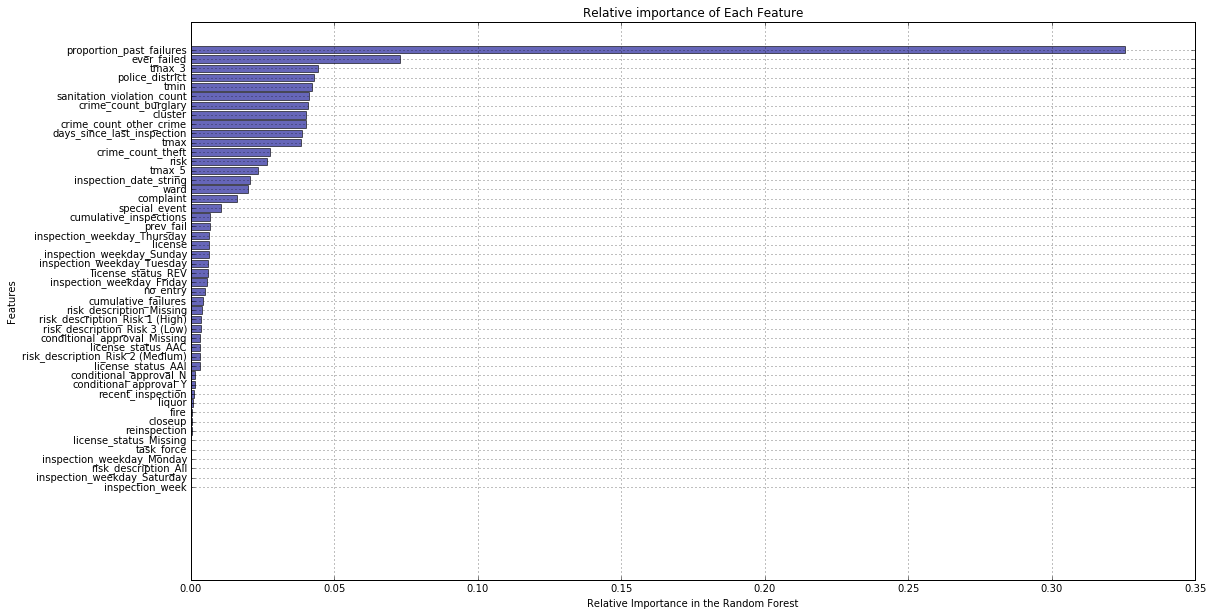

In [201]:
plt.figure(figsize=(18, 10))
plt.barh(range(len(name_list)),importance_list,align='center', color = "darkblue", alpha = 0.6)
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.grid()
plt.show()


## Model tuning

In [203]:
# Time series split
np.random.seed(123) # Set random seed
max_features = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20]

# Create numpy arrays
np_x_train = x_train.values
np_x_test = x_test.values
np_y_train = y_train.values
np_y_test = x_test.values

# Create generator
time_series_generator = TimeSeriesSplit(n_splits=10).split(np_x_train)


In [63]:
y_validate_train

array([[0],
       [1],
       [1],
       ..., 
       [1],
       [1],
       [1]])